# Customer Query Classification
### Hoori Javadnia & Fatemeh Khosravi

### Exploratory Data Analysis

In [4]:
#!pip install --upgrade emoji
#!pip install plotly
#!python -m nltk.downloader stopwords
#!pip install pyLDAvis==3.4.1

In [1]:
import pandas as pd
import numpy as np
import requests
import time
import random
from collections import OrderedDict
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px
import nltk
import random
py.init_notebook_mode(connected=True)
from nltk.stem import WordNetLemmatizer
from random import randint
color = sns.color_palette()
%matplotlib inline
from collections import Counter, defaultdict
from string import punctuation
from nltk.corpus import stopwords
from nltk.metrics import ConfusionMatrix
import plotly.io as pio
from nltk.tokenize import word_tokenize
re.compile('<title>(.*)</title>')
import nltk
import os
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
sw = set(stopwords.words('english'))
import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

### Read the Data

In [2]:
#Read the data

customer_queries = pd.read_csv('customer_query.csv')

### Dimension

The dataset consists of 40,267 samples (queries) with response variable in the 'Class' Column.

In [3]:
#Dimension of the data set

print(customer_queries.shape)

#10 samples from data set

customer_queries.sample(10)

(40267, 2)


,Query,Class
22027,\r\n\r\nWhat step should I take if I would lik...,Returns
15946,\r\n\r\nCould I please get a breakdown of the ...,Billing
8188,\r\n\r\nMy computer has recently been producin...,Tech. Support
33346,\r\n\r\nCan you explain the details regarding ...,Product Inquiry
9265,\r\n\r\nHave you had an chance to review your ...,Billing
24195,\r\n\r\nHas this order been billed to my credi...,Billing
13425,\r\n\r\nHow do I let multiple visitors simulta...,Tech. Support
25608,\r\n\r\nWill this area rug work well in a busy...,Product Inquiry
31773,\r\n\r\nDid you Authorize this charge of $35.0...,Billing
16805,"\r\n\r\nWhat is my current balance due, and wh...",Billing


### Check the Balance

Data set has 4 different classes: ‘Billing', 'Product Inquiry, 'Return' and 'Tech. Support’. According to the barplot, the dataset is balanced.

In [4]:
# Check different classes of the response variable

customer_queries['Class'].value_counts()

Class
Billing            10069
Product Inquiry    10067
Returns            10066
Tech. Support      10065
Name: count, dtype: int64

<Axes: title={'center': "' Barplot of the Class Values'"}, xlabel='Class'>

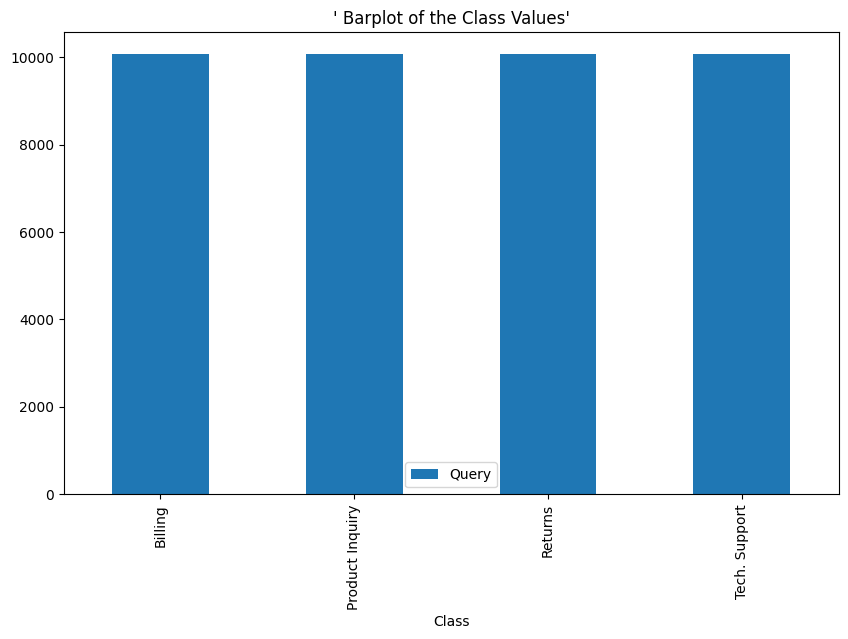

In [5]:
# Barplot of the 'Class' values

customer_queries.groupby('Class').agg({'Query': 'count'}).plot.bar(figsize=(10,6),
                                    title="' Barplot of the Class Values'")

### Clean the Data

In [6]:
# Some punctuation variations

punctuation = set(punctuation) #Creates a set of punctuation marks for later use.


# Stopwords
#Loads a list of stopwords for the English language.

sw = stopwords.words("english")


# useful regex
#Compiles a regular expression pattern to match whitespace.
whitespace_pattern = re.compile(r"\s+")


#Descriptive function
#This function takes a list of tokens as input and calculates various statistics
#such as the total number of tokens, the number of unique tokens, the number of characters,
#and the lexical diversity. It also prints the top num_tokens most common tokens if specified.


def descriptive_stats(tokens, num_tokens = 10, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    if verbose :
        print(f"There are {len(tokens)} tokens in the data.")
        print(f"There are {len(set(tokens))} unique tokens in the data.")
        print(f"There are {len(''.join(tokens))} characters in the data.")
        print(f"The lexical diversity is {len(set(tokens))/len(tokens):.3f} in the data.")

        counts = Counter(tokens)

        if num_tokens > 0 :
            print("The top ten most common tokens are:")
            top_tokens=counts.most_common(num_tokens)
            top_token_df = pd.DataFrame(top_tokens, columns = ["Token", "Frequency"])
            print(top_token_df)

    return([len(tokens),
           len(set(tokens)),
           len("".join(tokens)),
           len(set(tokens))/len(tokens)])





# Remove stop words  from a list of tokens

def remove_stop(tokens) :
    return([t for t in tokens if t.lower() not in sw])

# Remove punctuation

#Removes punctuation marks from a given text.
def remove_punctuation(text, punct_set=punctuation) :
    return("".join([ch for ch in text if ch not in punct_set]))

#Remove white space
#Replaces multiple consecutive whitespace characters with a single space
def remove_whitespace(text):
    text = whitespace_pattern.sub(r" ", text)
    return text

# Tokenization
#Splits a given text into tokens using whitespace as the delimiter
def tokenize(text) :
    """ Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """

    return([t for t in whitespace_pattern.split(text) if t])

# pipeline function

#Takes a text and a list of transformation functions as input.
#It applies each function in the pipeline to the text sequentially,
#modifying the text along the way.


def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)



#Overall,this code provides a set of utility functions for text preprocessing and
#descriptive analysis. It can be used to clean and analyze text data by applying various
#transformations and computing statistics on the processed text.

In [7]:
# Apply processing pipeline




#processing pipeline that consists of a sequence of functions to be applied to the text data.
#The functions in the pipeline are str.lower (converts text to lowercase),
#remove_punctuation (removes punctuation marks), remove_whitespace (replaces multiple consecutive whitespace characters with a single space),
#tokenize (splits text into tokens), and remove_stop (removes stopwords).

prep_pipeline = [str.lower, remove_punctuation,remove_whitespace, tokenize, remove_stop]

# Tokenization on 'Query' column
#The prepare function takes the text and the pipeline as inputs, applies each transformation function in the pipeline sequentially, and returns the resulting tokens. The tokens are assigned to a new column named "tokens" in the DataFrame.


customer_queries["tokens"] = customer_queries["Query"].apply(prepare, pipeline = prep_pipeline)

# Count number of tokens in each row

customer_queries["num_tokens"] = customer_queries["tokens"].map(len)

customer_queries.sample(10)


,Query,Class,tokens,num_tokens
18802,\r\n\r\nWhy has my returned delivery not arriv...,Returns,"[returned, delivery, arrived, yet, shipped, vi...",15
12035,\r\n\r\nDo ALL SALES purchases come with a ret...,Returns,"[sales, purchases, come, returnexchange, option]",5
36957,\r\n\r\nI saw an incorrect charge on my statem...,Billing,"[saw, incorrect, charge, statement, options, r...",6
31312,\r\n\r\nI was recently checking my statement a...,Billing,"[recently, checking, statement, appears, unaut...",17
12504,\r\n\r\nI unknowingly unpinned an item I rarel...,Tech. Support,"[unknowingly, unpinned, item, rarely, use, pro...",11
7531,\r\n\r\nMy document isn't responding when I tr...,Tech. Support,"[document, isnt, responding, try, print]",5
18550,\r\n\r\nCan I return this item as I changed my...,Returns,"[return, item, changed, mind, purchase, decision]",6
24750,\r\n Bob exercised a few additional services o...,Billing,"[bob, exercised, additional, services, service...",20
6747,\r\n\r\nHow can I connect my laptop to the pri...,Tech. Support,"[connect, laptop, printer, wirelessly]",4
569,\r\n\r\nI was reading about your clothing digi...,Product Inquiry,"[reading, clothing, digital, fabric, collectio...",15


### Descriptive Statistics

Descriptive statistics output is displayed in the code snippet below.
'return', 'product', 'item', 'purchased' and 'payment' are the top ten most common tokens in this dataset.

In [8]:
# We need to transform the Query to lists of tokens for descriptive statistics

tokens_list = customer_queries['tokens'].to_list()

# convert nested list to a flat list

tokens_list  = [item for sublist in tokens_list  for item in sublist]

In [9]:
print("Descriptive Stats:\n")

print(descriptive_stats(tokens_list ))


Descriptive Stats:

There are 364359 tokens in the data.
There are 20993 unique tokens in the data.
There are 2295191 characters in the data.
The lexical diversity is 0.058 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8343
1    product       6413
2       item       5398
3  purchased       4106
4    payment       3736
5   recently       3689
6      order       3281
7     please       3227
8         im       3200
9       need       3171
[364359, 20993, 2295191, 0.057616252103008296]


### Query Lengths

Here we can see the distribution histogram of lengths of queries ( number of tokens ) based on its class.
* According to this plot ‘Billing’ and ‘Returns’ categories have the highest number of tokens in the query (38 and 35 tokens, respectively).
* The average number of tokens for all classes is about 10 tokens.  

Class
Billing            Axes(0.125,0.11;0.775x0.77)
Product Inquiry    Axes(0.125,0.11;0.775x0.77)
Returns            Axes(0.125,0.11;0.775x0.77)
Tech. Support      Axes(0.125,0.11;0.775x0.77)
Name: num_tokens, dtype: object

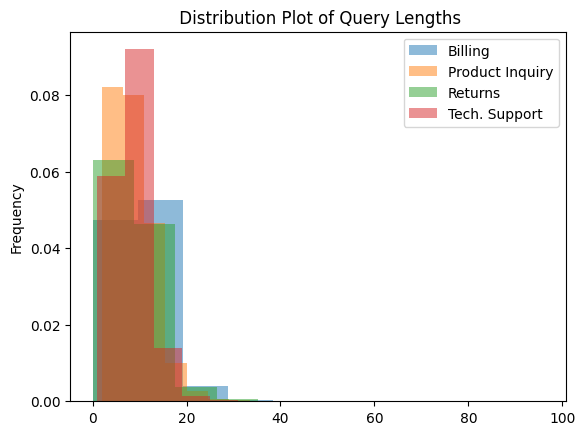

In [10]:
customer_queries.groupby('Class')['num_tokens'].plot(kind="hist",density=True,alpha=0.5,
                         legend=True, title= " Distribution Plot of Query Lengths")

### Descriptive Statistics of Each Class

* Lexical diversity for 'Product Inquiry' class is about 0.127 and for 'Billing' and 'Tech. Support' classes is about 0.078. The lowest lexical diversity belongs to the 'Return' class with 0.065. Higher value means that the queries contain many different word types while lower value of lexical diversity refers to the repeated words or phrases.

* By removing punctuation in the way we did, a number of pairs of stopwords (e.g., "I am" and "is not") show up in the top 10 tokens.

In [11]:
# Billing

billing_query= customer_queries.loc[customer_queries['Class']== 'Billing'].tokens.to_list()
billing_query = [item for sublist in billing_query for item in sublist]


#Product Inquiry

product_query = customer_queries.loc[customer_queries['Class']== 'Product Inquiry'].tokens.to_list()
product_query = [item for sublist in product_query for item in sublist]


# Returns

return_query= customer_queries.loc[customer_queries['Class']== 'Returns'].tokens.to_list()
return_query= [item for sublist in return_query for item in sublist]


#Tech.Support

tech_query = customer_queries.loc[customer_queries['Class']== 'Tech. Support'].tokens.to_list()
tech_query = [item for sublist in tech_query for item in sublist]

In [12]:
# Descriptive Statistics of Billing Class

print("Descriptive Statistics of Billing Class:\n")

print(descriptive_stats(billing_query, num_tokens=10 ))


Descriptive Statistics of Billing Class:

There are 108398 tokens in the data.
There are 8470 unique tokens in the data.
There are 683268 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
       Token  Frequency
0    payment       3642
1     please       2288
2    billing       2269
3       bill       1710
4      order       1640
5    invoice       1568
6    account       1225
7   purchase       1117
8       card       1090
9  statement       1078
[108398, 8470, 683268, 0.07813797302533257]


In [13]:
# Descriptive Statistics of Product Inquiry Class

print("Descriptive Statistics of Product Inquiry Class:\n")

print(descriptive_stats(product_query, num_tokens=10 ))


Descriptive Statistics of Product Inquiry Class:

There are 86000 tokens in the data.
There are 10881 unique tokens in the data.
There are 552211 characters in the data.
The lexical diversity is 0.127 in the data.
The top ten most common tokens are:
       Token  Frequency
0    product       4381
1         im       1328
2  available        731
3       come        692
4       size        679
5        use        644
6   products        595
7    looking        587
8   warranty        571
9       type        567
[86000, 10881, 552211, 0.1265232558139535]


In [14]:
# Descriptive Statistics of Return Class

print("Descriptive Statistics of Return Class:\n")

print(descriptive_stats(return_query, num_tokens=10 ))


Descriptive Statistics of Return Class:

There are 88127 tokens in the data.
There are 5765 unique tokens in the data.
There are 556304 characters in the data.
The lexical diversity is 0.065 in the data.
The top ten most common tokens are:
       Token  Frequency
0     return       8042
1       item       4785
2  purchased       3227
3   recently       2291
4     refund       1961
5    product       1809
6    process       1729
7     policy       1563
8  returning       1336
9       need       1310
[88127, 5765, 556304, 0.06541695507619685]


In [15]:
# Descriptive Statistics of Tech. Support Class

print("Descriptive Statistics of Tech. Support Class:\n")

print(descriptive_stats(tech_query, num_tokens=10 ))

Descriptive Statistics of Tech. Support Class:

There are 81834 tokens in the data.
There are 6363 unique tokens in the data.
There are 503408 characters in the data.
The lexical diversity is 0.078 in the data.
The top ten most common tokens are:
      Token  Frequency
0    laptop       2343
1  computer       2168
2      wont       1769
3   printer       1443
4     issue       1145
5      wifi       1114
6      isnt       1091
7       fix       1056
8      turn       1030
9        im        992
[81834, 6363, 503408, 0.07775496737297456]


### Find tokens uniquely related to a corpus

In this section we find 10 tokens for each of four classes that meet the following criteria:

1. The token appears at least 5 times in all classes.
1. The tokens are in the top 10 for the highest ratio of appearances in a given class vs appearances in other class.


In [16]:
# Billing Class

billing_count={'token':[], 'class1 count':[], 'concentration1':[]}
billing_tokens=customer_queries.loc[customer_queries['Class']=='Billing','tokens']
billing_tokens=list(billing_tokens)
billing_tokens=[element for innerList in billing_tokens for element in innerList]
billing_counter=Counter(billing_tokens)

for t in billing_counter:
        if billing_counter[t] >=5:
            billing_count['token'].append(t)
            billing_count['class1 count'].append(billing_counter[t])
            concentration1 = billing_counter[t]/len(billing_tokens)
            billing_count['concentration1'].append(concentration1)


billing_count_df=pd.DataFrame(billing_count)



# Product Inquiry class

Product_count={'token':[], 'class2 count':[], 'concentration2':[]}
Product_tokens=customer_queries.loc[customer_queries['Class']=='Product Inquiry','tokens']
Product_tokens=list(Product_tokens)
Product_tokens=[element for innerList in Product_tokens for element in innerList]
Product_counter=Counter(Product_tokens)

for t in Product_counter:
        if Product_counter[t] >=5:
            Product_count['token'].append(t)
            Product_count['class2 count'].append(Product_counter[t])
            concentration2 = Product_counter[t]/len(Product_tokens)
            Product_count['concentration2'].append(concentration2)


Product_count_df=pd.DataFrame(Product_count)




# Return class

Return_count={'token':[], 'class3 count':[], 'concentration3':[]}
Return_tokens=customer_queries.loc[customer_queries['Class']=='Returns','tokens']
Return_tokens=list(Return_tokens)
Return_tokens=[element for innerList in Return_tokens for element in innerList]
Return_counter=Counter(Return_tokens)

for t in Return_counter:
        if Return_counter[t] >=5:
            Return_count['token'].append(t)
            Return_count['class3 count'].append(Return_counter[t])
            concentration3 = Return_counter[t]/len(Return_tokens)
            Return_count['concentration3'].append(concentration3)


Return_count_df=pd.DataFrame(Return_count)




# Tech. Support class

Tech_count={'token':[], 'class4 count':[], 'concentration4':[]}
Tech_tokens=customer_queries.loc[customer_queries['Class']=='Tech. Support','tokens']
Tech_tokens=list(Tech_tokens)
Tech_tokens=[element for innerList in Tech_tokens for element in innerList]
Tech_counter=Counter(Tech_tokens)

for t in Tech_counter:
        if Tech_counter[t] >=5:
            Tech_count['token'].append(t)
            Tech_count['class4 count'].append(Tech_counter[t])
            concentration4 = Tech_counter[t]/len(Tech_tokens)
            Tech_count['concentration4'].append(concentration4)


Tech_count_df=pd.DataFrame(Tech_count)



# merge four data frames

final_count_df = pd.merge(pd.merge(pd.merge(billing_count_df,Product_count_df,on='token'),
                                   Return_count_df,on='token'),Tech_count_df,on='token')




#ratio

final_count_df['concentration_ratio (1,2)']=final_count_df['concentration1']/final_count_df['concentration2']
final_count_df['concentration_ratio (1,3)']=final_count_df['concentration1']/final_count_df['concentration3']
final_count_df['concentration_ratio (1,4)']=final_count_df['concentration1']/final_count_df['concentration4']
final_count_df['concentration_ratio (2,3)']=final_count_df['concentration2']/final_count_df['concentration3']
final_count_df['concentration_ratio (2,4)']=final_count_df['concentration2']/final_count_df['concentration4']
final_count_df['concentration_ratio (3,4)']=final_count_df['concentration3']/final_count_df['concentration4']


final_count_df.sample(10)

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
229,special,53,0.000489,104,0.001209,21,0.000238,6,0.000073,0.404315,2.051844,6.668638,5.074866,16.493674,3.250071
223,return,38,0.000351,255,0.002965,8042,0.091255,8,0.000098,0.118228,0.003842,3.585966,0.032493,30.330916,933.466798
376,without,25,0.000231,89,0.001035,50,0.000567,67,0.000819,0.222857,0.406497,0.281694,1.824024,1.264010,0.692979
404,taking,11,0.000101,15,0.000174,11,0.000125,43,0.000525,0.581807,0.812995,0.193124,1.397363,0.331939,0.237547
284,7,12,0.000111,15,0.000174,9,0.000102,10,0.000122,0.634698,1.083993,0.905928,1.707888,1.427337,0.835733
330,couple,10,0.000092,11,0.000128,23,0.000261,22,0.000269,0.721248,0.353476,0.343155,0.490089,0.475779,0.970800
346,track,28,0.000258,26,0.000302,9,0.000102,9,0.000110,0.854401,2.529317,2.348703,2.960339,2.748946,0.928592
142,updates,21,0.000194,23,0.000267,6,0.000068,83,0.001014,0.724384,2.845481,0.191009,3.928141,0.263685,0.067127
85,may,324,0.002989,37,0.000430,127,0.001441,41,0.000501,6.947371,2.074097,5.965868,0.298544,0.858723,2.876369
132,become,14,0.000129,10,0.000116,5,0.000057,16,0.000196,1.110722,2.276385,0.660573,2.049465,0.594724,0.290185


We sort data frame based on 'concentration ratio (1,2) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Billing' class vs appearances in 'Product Inquiry' class. This tokens are:

* charged, payment, recent, account, month, due, address, method, pay, card.



In [17]:
# Top 10 tokens uniquely related to 'Billing' class vs  'Product Inquiry' class
final_count_df.sort_values('concentration_ratio (1,2)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
2,charged,853,0.007869,5,0.000058,25,0.000284,20,0.000244,135.349361,27.739379,32.198196,0.204947,0.237890,1.160740
7,payment,3642,0.033598,27,0.000314,56,0.000635,11,0.000134,107.017145,52.873691,249.953813,0.494067,2.335643,4.727376
14,recent,981,0.009050,12,0.000140,142,0.001611,39,0.000477,64.858208,5.616534,18.989648,0.086597,0.292787,3.381026
116,account,1225,0.011301,15,0.000174,60,0.000681,338,0.004130,64.792093,16.598642,2.736100,0.256183,0.042229,0.164839
36,month,655,0.006043,9,0.000105,77,0.000874,7,0.000086,57.739893,6.915734,70.640826,0.119774,1.223432,10.214509
75,due,933,0.008607,13,0.000151,101,0.001146,9,0.000110,56.939739,7.510139,78.262127,0.131896,1.374473,10.420862
10,address,618,0.005701,11,0.000128,61,0.000692,38,0.000464,44.573114,8.236569,12.277711,0.184788,0.275451,1.490634
137,method,321,0.002961,6,0.000070,35,0.000397,7,0.000086,42.445433,7.456323,34.619397,0.175668,0.815621,4.642958
27,pay,687,0.006338,13,0.000151,34,0.000386,6,0.000073,41.926689,16.427275,86.440645,0.391810,2.061709,5.262020
8,card,1090,0.010056,22,0.000256,44,0.000499,56,0.000684,39.308005,20.140096,14.694370,0.512366,0.373826,0.729608


We sort data frame based on 'concentration ratio (1,2) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Product Inquiry' class vs appearances in 'Billing' class. This token are:

* model, size, warranty, fit, buy,features, easy, product, performance, replacement.


In [18]:
# Top 10 tokens uniquely related to 'Product Inquiry' class vs 'Billing' class
final_count_df.sort_values('concentration_ratio (1,2)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
415,model,5,0.000046,324,0.003767,23,0.000261,29,0.000354,0.012243,0.176738,0.130162,14.435363,10.631201,0.736469
367,size,14,0.000129,679,0.007895,360,0.004085,19,0.000232,0.016358,0.031616,0.556272,1.932759,34.005683,17.594369
285,warranty,12,0.000111,571,0.006640,39,0.000443,21,0.000257,0.016673,0.250152,0.431394,15.003136,25.873319,1.724527
79,fit,5,0.000046,227,0.002640,302,0.003427,5,0.000061,0.017475,0.013460,0.754940,0.770246,43.200740,56.086938
382,buy,7,0.000065,315,0.003663,12,0.000136,5,0.000061,0.017631,0.474247,1.056916,26.899230,59.948163,2.228620
386,features,13,0.000120,493,0.005733,7,0.000079,33,0.000403,0.020921,1.509847,0.297401,72.170450,14.215702,0.196974
411,easy,7,0.000065,167,0.001942,26,0.000295,20,0.000244,0.033255,0.218883,0.264229,6.581936,7.945510,1.207169
139,product,195,0.001799,4381,0.050942,1809,0.020527,28,0.000342,0.035313,0.087636,5.257619,2.481677,148.884865,59.993656
241,performance,5,0.000046,100,0.001163,5,0.000057,57,0.000697,0.039669,0.812995,0.066223,20.494651,1.669400,0.081455
286,replacement,7,0.000065,137,0.001593,162,0.001838,7,0.000086,0.040537,0.035129,0.754940,0.866595,18.623352,21.490265


We sort data frame based on 'concentration ratio (1,3) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Billing' class vs appearances in 'Return' class . This tokens are:

* payment,charge,latest,charged,current,plan, services,amount,card, including.

In [19]:
# Top 10 tokens uniquely related to 'Billing' class vs  'Return' class
final_count_df.sort_values('concentration_ratio (1,3)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
7,payment,3642,0.033598,27,0.000314,56,0.000635,11,0.000134,107.017145,52.873691,249.953813,0.494067,2.335643,4.727376
16,charge,920,0.008487,26,0.000302,20,0.000227,47,0.000574,28.073183,37.397756,14.777551,1.332152,0.526394,0.395145
100,latest,239,0.002205,42,0.000488,6,0.000068,82,0.001002,4.514668,32.384289,2.200374,7.173128,0.487383,0.067946
2,charged,853,0.007869,5,0.000058,25,0.000284,20,0.000244,135.349361,27.739379,32.198196,0.204947,0.237890,1.160740
148,current,506,0.004668,43,0.000500,15,0.000170,20,0.000244,9.335966,27.425021,19.099985,2.937567,2.045850,0.696444
37,plan,438,0.004041,44,0.000512,13,0.000148,14,0.000171,7.897663,27.391668,23.618841,3.468326,2.990611,0.862264
133,services,400,0.003690,35,0.000407,12,0.000136,15,0.000183,9.067115,27.099823,20.131737,2.988803,2.220302,0.742873
45,amount,1046,0.009650,26,0.000302,36,0.000409,8,0.000098,31.917989,23.622013,98.708422,0.740085,3.092564,4.178663
8,card,1090,0.010056,22,0.000256,44,0.000499,56,0.000684,39.308005,20.140096,14.694370,0.512366,0.373826,0.729608
93,including,228,0.002103,9,0.000105,11,0.000125,5,0.000061,20.098772,16.851163,34.425270,0.838418,1.712805,2.042902


We sort data frame based on 'concentration ratio (1,3) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Return' class vs appearances in 'Billing' class . This tokens are:

* return, fit, bought, size, replacement, opened, store, item, purchased, broken.

In [20]:
# Top 10 tokens uniquely related to 'Return' class vs 'Billing' class
final_count_df.sort_values('concentration_ratio (1,3)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
223,return,38,0.000351,255,0.002965,8042,0.091255,8,0.000098,0.118228,0.003842,3.585966,0.032493,30.330916,933.466798
79,fit,5,0.000046,227,0.002640,302,0.003427,5,0.000061,0.017475,0.013460,0.754940,0.770246,43.200740,56.086938
160,bought,25,0.000231,259,0.003012,683,0.007750,68,0.000831,0.076580,0.029758,0.277552,0.388588,3.624317,9.326884
367,size,14,0.000129,679,0.007895,360,0.004085,19,0.000232,0.016358,0.031616,0.556272,1.932759,34.005683,17.594369
286,replacement,7,0.000065,137,0.001593,162,0.001838,7,0.000086,0.040537,0.035129,0.754940,0.866595,18.623352,21.490265
414,opened,8,0.000074,12,0.000140,149,0.001691,10,0.000122,0.528915,0.043651,0.603952,0.082529,1.141870,13.836016
157,store,81,0.000747,278,0.003233,1201,0.013628,25,0.000305,0.231163,0.054831,2.446006,0.237199,10.581327,44.609545
156,item,339,0.003127,257,0.002988,4785,0.054297,17,0.000208,1.046511,0.057598,15.054394,0.055038,14.385320,261.371250
54,purchased,259,0.002389,504,0.005860,3227,0.036618,116,0.001418,0.407705,0.065251,1.685599,0.160045,4.134356,25.832460
421,broken,6,0.000055,12,0.000140,71,0.000806,15,0.000183,0.396686,0.068704,0.301976,0.173194,0.761247,4.395334


We sort data frame based on 'concentration ratio (1,4) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Billing' class vs appearances in 'Tech. Support' class. This tokens are:

* payment, amount,pay, due, month,purchase, details,method,including, date.

In [21]:
# Top 10 tokens uniquely related to 'Billing' class vs  'Tech. Support' class
final_count_df.sort_values('concentration_ratio (1,4)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
7,payment,3642,0.033598,27,0.000314,56,0.000635,11,0.000134,107.017145,52.873691,249.953813,0.494067,2.335643,4.727376
45,amount,1046,0.009650,26,0.000302,36,0.000409,8,0.000098,31.917989,23.622013,98.708422,0.740085,3.092564,4.178663
27,pay,687,0.006338,13,0.000151,34,0.000386,6,0.000073,41.926689,16.427275,86.440645,0.391810,2.061709,5.262020
75,due,933,0.008607,13,0.000151,101,0.001146,9,0.000110,56.939739,7.510139,78.262127,0.131896,1.374473,10.420862
36,month,655,0.006043,9,0.000105,77,0.000874,7,0.000086,57.739893,6.915734,70.640826,0.119774,1.223432,10.214509
15,purchase,1117,0.010305,498,0.005791,1108,0.012573,15,0.000183,1.779512,0.819598,56.217875,0.460575,31.591730,68.591973
57,details,459,0.004234,67,0.000779,85,0.000965,10,0.000122,5.435194,4.390171,34.651752,0.807730,6.375440,7.893029
137,method,321,0.002961,6,0.000070,35,0.000397,7,0.000086,42.445433,7.456323,34.619397,0.175668,0.815621,4.642958
93,including,228,0.002103,9,0.000105,11,0.000125,5,0.000061,20.098772,16.851163,34.425270,0.838418,1.712805,2.042902
52,date,513,0.004733,42,0.000488,52,0.000590,12,0.000147,9.690479,8.020505,32.273690,0.827669,3.330453,4.023897


We sort data frame based on 'concentration ratio (1,4) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Tech. Support' class vs 'Billing' class. This tokens are:

* computer, printer, wont, fix, working,try, print,isnt, software,device.

In [22]:
# Top 10 tokens uniquely related to 'Tech. Support' class vs 'Billing' class
final_count_df.sort_values('concentration_ratio (1,4)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
363,computer,6,0.000055,73,0.000849,8,0.000091,2168,0.026493,0.065209,0.609746,0.002089,9.350685,0.032040,0.003427
416,printer,5,0.000046,76,0.000884,6,0.000068,1443,0.017633,0.052196,0.677496,0.002616,12.979946,0.050117,0.003861
301,wont,15,0.000138,47,0.000547,18,0.000204,1769,0.021617,0.253204,0.677496,0.006401,2.675691,0.025282,0.009449
331,fix,10,0.000092,39,0.000453,8,0.000091,1056,0.012904,0.203429,1.016243,0.007149,4.995571,0.035143,0.007035
397,working,16,0.000148,81,0.000942,148,0.001679,914,0.011169,0.156716,0.087891,0.013216,0.560833,0.084328,0.150363
398,try,10,0.000092,25,0.000291,8,0.000091,553,0.006758,0.317349,1.016243,0.013652,3.202289,0.043018,0.013434
343,print,7,0.000065,14,0.000163,7,0.000079,300,0.003666,0.396686,0.812995,0.017615,2.049465,0.044406,0.021667
34,isnt,26,0.000240,58,0.000674,98,0.001112,1091,0.013332,0.355650,0.215692,0.017991,0.606474,0.050587,0.083412
394,software,11,0.000101,62,0.000721,7,0.000079,419,0.005120,0.140760,1.277563,0.019819,9.076203,0.140803,0.015513
387,device,9,0.000083,101,0.001174,11,0.000125,287,0.003507,0.070697,0.665177,0.023674,9.408908,0.334869,0.035591


We sort data frame based on 'concentration ratio (2,3) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Product Inquiry' class vs 'Return' class. This tokens are:

* features, comes, types, buy, performance, warranty, come, model, printer, type.

In [23]:
# Top 10 tokens uniquely related to 'Product Inquiry' class vs 'Return' class
final_count_df.sort_values('concentration_ratio (2,3)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
386,features,13,0.000120,493,0.005733,7,0.000079,33,0.000403,0.020921,1.509847,0.297401,72.170450,14.215702,0.196974
272,comes,14,0.000129,153,0.001779,5,0.000057,9,0.000110,0.072596,2.276385,1.174351,31.356816,16.176488,0.515884
361,types,22,0.000203,137,0.001593,5,0.000057,5,0.000061,0.127403,3.577177,3.321737,28.077672,26.072693,0.928592
382,buy,7,0.000065,315,0.003663,12,0.000136,5,0.000061,0.017631,0.474247,1.056916,26.899230,59.948163,2.228620
241,performance,5,0.000046,100,0.001163,5,0.000057,57,0.000697,0.039669,0.812995,0.066223,20.494651,1.669400,0.081455
285,warranty,12,0.000111,571,0.006640,39,0.000443,21,0.000257,0.016673,0.250152,0.431394,15.003136,25.873319,1.724527
235,come,50,0.000461,692,0.008047,49,0.000556,42,0.000513,0.057325,0.829586,0.898738,14.471733,15.678053,1.083357
415,model,5,0.000046,324,0.003767,23,0.000261,29,0.000354,0.012243,0.176738,0.130162,14.435363,10.631201,0.736469
416,printer,5,0.000046,76,0.000884,6,0.000068,1443,0.017633,0.052196,0.677496,0.002616,12.979946,0.050117,0.003861
224,type,61,0.000563,567,0.006593,49,0.000556,65,0.000794,0.085354,1.012095,0.708482,11.857620,8.300515,0.700015


We sort data frame based on 'concentration ratio (2,3) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Return' class vs 'Product Inquiry' class. This tokens are:

* return, incorrect, yesterday, sent, send, process, item, request, received, processing.

In [24]:
# Top 10 tokens uniquely related to  'Return' class vs 'Product Inquiry' class
final_count_df.sort_values('concentration_ratio (2,3)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
223,return,38,0.000351,255,0.002965,8042,0.091255,8,0.000098,0.118228,0.003842,3.585966,0.032493,30.330916,933.466798
305,incorrect,135,0.001245,5,0.000058,152,0.001725,21,0.000257,21.421059,0.722068,4.853187,0.033708,0.226561,6.721235
267,yesterday,73,0.000673,10,0.000116,240,0.002723,46,0.000562,5.791620,0.247286,1.198057,0.042697,0.206860,4.844826
83,sent,166,0.001531,5,0.000058,119,0.001350,18,0.000220,26.339969,1.134093,6.962226,0.043056,0.264322,6.139023
12,send,127,0.001172,7,0.000081,164,0.001861,53,0.000648,14.394045,0.629575,1.809007,0.043739,0.125677,2.873378
104,process,267,0.002463,86,0.001000,1729,0.019619,42,0.000513,2.463145,0.125546,4.799262,0.050970,1.948429,38.227025
156,item,339,0.003127,257,0.002988,4785,0.054297,17,0.000208,1.046511,0.057598,15.054394,0.055038,14.385320,261.371250
179,request,45,0.000415,9,0.000105,150,0.001702,11,0.000134,3.966863,0.243898,3.088391,0.061484,0.778548,12.662614
70,received,818,0.007546,75,0.000872,1120,0.012709,30,0.000367,8.653050,0.593776,20.584701,0.068620,2.378895,34.667423
155,processing,120,0.001107,7,0.000081,98,0.001112,8,0.000098,13.600673,0.995504,11.324102,0.073195,0.832613,11.375248


We sort data frame based on 'concentration ratio (2,4) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Product Inquiry' class vs 'Tech. Support' class. This tokens are:

* product, products, looking, buy, fit, size, purchase, return, wondering, types.

In [25]:
# Top 10 tokens uniquely related to  'Product Inquiry' class vs 'Tech. Support' class
final_count_df.sort_values('concentration_ratio (2,4)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
139,product,195,0.001799,4381,0.050942,1809,0.020527,28,0.000342,0.035313,0.087636,5.257619,2.481677,148.884865,59.993656
144,products,99,0.000913,595,0.006919,242,0.002746,8,0.000098,0.132007,0.332589,9.342384,2.519487,70.772137,28.089899
89,looking,65,0.000600,587,0.006826,86,0.000976,8,0.000098,0.087852,0.614473,6.133889,6.994395,69.820578,9.982361
382,buy,7,0.000065,315,0.003663,12,0.000136,5,0.000061,0.017631,0.474247,1.056916,26.899230,59.948163,2.228620
79,fit,5,0.000046,227,0.002640,302,0.003427,5,0.000061,0.017475,0.013460,0.754940,0.770246,43.200740,56.086938
367,size,14,0.000129,679,0.007895,360,0.004085,19,0.000232,0.016358,0.031616,0.556272,1.932759,34.005683,17.594369
15,purchase,1117,0.010305,498,0.005791,1108,0.012573,15,0.000183,1.779512,0.819598,56.217875,0.460575,31.591730,68.591973
223,return,38,0.000351,255,0.002965,8042,0.091255,8,0.000098,0.118228,0.003842,3.585966,0.032493,30.330916,933.466798
201,wondering,77,0.000710,551,0.006407,72,0.000817,20,0.000244,0.110871,0.869453,2.906519,7.842051,26.215427,3.342930
361,types,22,0.000203,137,0.001593,5,0.000057,5,0.000061,0.127403,3.577177,3.321737,28.077672,26.072693,0.928592


We sort data frame based on 'concentration ratio (2,4) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Tech. Support' vs 'Product Inquiry' class. This tokens are:

* wont, computer, update, fix, though, unable,open, account,try, print.

In [26]:
# Top 10 tokens uniquely related to  'Tech. Support' vs 'Product Inquiry' class
final_count_df.sort_values('concentration_ratio (2,4)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
301,wont,15,0.000138,47,0.000547,18,0.000204,1769,0.021617,0.253204,0.677496,0.006401,2.675691,0.025282,0.009449
363,computer,6,0.000055,73,0.000849,8,0.000091,2168,0.026493,0.065209,0.609746,0.002089,9.350685,0.032040,0.003427
209,update,253,0.002334,9,0.000105,38,0.000431,255,0.003116,22.302585,5.412833,0.749019,0.242700,0.033584,0.138378
331,fix,10,0.000092,39,0.000453,8,0.000091,1056,0.012904,0.203429,1.016243,0.007149,4.995571,0.035143,0.007035
5,though,23,0.000212,5,0.000058,47,0.000533,134,0.001637,3.649514,0.397848,0.129579,0.109014,0.035506,0.325700
315,unable,27,0.000249,6,0.000070,15,0.000170,138,0.001686,3.570177,1.463390,0.147706,0.409893,0.041372,0.100934
166,open,26,0.000240,12,0.000140,26,0.000295,274,0.003348,1.718974,0.812995,0.071637,0.472953,0.041674,0.088115
116,account,1225,0.011301,15,0.000174,60,0.000681,338,0.004130,64.792093,16.598642,2.736100,0.256183,0.042229,0.164839
398,try,10,0.000092,25,0.000291,8,0.000091,553,0.006758,0.317349,1.016243,0.013652,3.202289,0.043018,0.013434
343,print,7,0.000065,14,0.000163,7,0.000079,300,0.003666,0.396686,0.812995,0.017615,2.049465,0.044406,0.021667


We sort data frame based on 'concentration ratio (3,4) ' column in descending order. The tokens are in the top 10 for the highest ratio of appearances in 'Return' vs 'Tech. Support' class. This tokens are:

* Return, item, items, purchase, product, fit, store, process, received, placed.

In [27]:
# Top 10 tokens uniquely related to  'Return' vs 'Tech. Support' class
final_count_df.sort_values('concentration_ratio (3,4)', ascending =False)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
223,return,38,0.000351,255,0.002965,8042,0.091255,8,0.000098,0.118228,0.003842,3.585966,0.032493,30.330916,933.466798
156,item,339,0.003127,257,0.002988,4785,0.054297,17,0.000208,1.046511,0.057598,15.054394,0.055038,14.385320,261.371250
53,items,349,0.003220,134,0.001558,1100,0.012482,14,0.000171,2.066321,0.257941,18.819579,0.124831,9.107771,72.960776
15,purchase,1117,0.010305,498,0.005791,1108,0.012573,15,0.000183,1.779512,0.819598,56.217875,0.460575,31.591730,68.591973
139,product,195,0.001799,4381,0.050942,1809,0.020527,28,0.000342,0.035313,0.087636,5.257619,2.481677,148.884865,59.993656
79,fit,5,0.000046,227,0.002640,302,0.003427,5,0.000061,0.017475,0.013460,0.754940,0.770246,43.200740,56.086938
157,store,81,0.000747,278,0.003233,1201,0.013628,25,0.000305,0.231163,0.054831,2.446006,0.237199,10.581327,44.609545
104,process,267,0.002463,86,0.001000,1729,0.019619,42,0.000513,2.463145,0.125546,4.799262,0.050970,1.948429,38.227025
70,received,818,0.007546,75,0.000872,1120,0.012709,30,0.000367,8.653050,0.593776,20.584701,0.068620,2.378895,34.667423
196,placed,141,0.001301,14,0.000163,160,0.001816,5,0.000061,7.990395,0.716452,21.289312,0.089664,2.664363,29.714934


We sort data frame based on 'concentration ratio (3,4) ' column in ascending order. The tokens are in the top 10 for the highest ratio of appearances in 'Tech. Support' class vs 'Return' class. This tokens are:

* computer, printer, fix, wont , try, software, cant, print, running, access.

In [28]:
# Top 10 tokens uniquely related to  'Tech. Support' class vs 'Return' class
final_count_df.sort_values('concentration_ratio (3,4)', ascending =True)[0:10]

,token,class1 count,concentration1,class2 count,concentration2,class3 count,concentration3,class4 count,concentration4,"concentration_ratio (1,2)","concentration_ratio (1,3)","concentration_ratio (1,4)","concentration_ratio (2,3)","concentration_ratio (2,4)","concentration_ratio (3,4)"
363,computer,6,0.000055,73,0.000849,8,0.000091,2168,0.026493,0.065209,0.609746,0.002089,9.350685,0.032040,0.003427
416,printer,5,0.000046,76,0.000884,6,0.000068,1443,0.017633,0.052196,0.677496,0.002616,12.979946,0.050117,0.003861
331,fix,10,0.000092,39,0.000453,8,0.000091,1056,0.012904,0.203429,1.016243,0.007149,4.995571,0.035143,0.007035
301,wont,15,0.000138,47,0.000547,18,0.000204,1769,0.021617,0.253204,0.677496,0.006401,2.675691,0.025282,0.009449
398,try,10,0.000092,25,0.000291,8,0.000091,553,0.006758,0.317349,1.016243,0.013652,3.202289,0.043018,0.013434
394,software,11,0.000101,62,0.000721,7,0.000079,419,0.005120,0.140760,1.277563,0.019819,9.076203,0.140803,0.015513
236,cant,35,0.000323,51,0.000593,17,0.000193,789,0.009641,0.544471,1.673813,0.033489,3.074198,0.061508,0.020008
343,print,7,0.000065,14,0.000163,7,0.000079,300,0.003666,0.396686,0.812995,0.017615,2.049465,0.044406,0.021667
364,running,12,0.000111,75,0.000872,7,0.000079,226,0.002762,0.126940,1.393705,0.040085,10.979277,0.315783,0.028762
204,access,93,0.000858,44,0.000512,11,0.000125,351,0.004289,1.676901,6.873501,0.200027,4.098930,0.119284,0.029101


### World Clouds for all Classes

In [29]:
# Define a Function


# This function generates a word cloud based on word frequencies.
# Parameters:
# - word_freq: The word frequencies, either a Pandas Series or a dictionary.
# - title: The title of the word cloud (optional).
# - max_words: The maximum number of words to display in the word cloud (default: 200).
# - stopwords: A list of stopwords to filter out from the word frequencies (optional).




def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")




# This function counts the frequencies of words in a specified column of a DataFrame.
# Parameters:
# - df: The DataFrame to count words from.
# - column: The column name containing the text data (default: 'tokens').
# - preprocess: A function to preprocess the text data (optional).
# - min_freq: The minimum frequency threshold for words to be included in the output (default: 2).



def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    # Sort the DataFrame by frequency in descending orde
    return freq_df.sort_values('freq', ascending=False)

In [30]:
# word counts for all classes

billing_query_count = count_words(customer_queries[customer_queries['Class']=="Billing"])
product_query_count = count_words(customer_queries[customer_queries['Class']=="Product Inquiry"])
return_query_count = count_words(customer_queries[customer_queries['Class']=="Returns"])
tech_query_count = count_words(customer_queries[customer_queries['Class']=="Tech. Support"])


#The code is performing word counts for different classes of customer queries.
#Each line filters the customer_queries DataFrame based on a specific class and then calls
#the count_words function to count the words in the filtered queries.
#The results are stored in separate variables for each class (billing_query_count, product_query_count, return_query_count, tech_query_count).

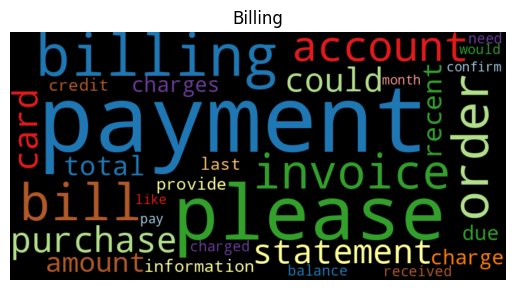

In [31]:
# Billing Class

wordcloud(billing_query_count['freq'], title="Billing", max_words=30, stopwords=None)
# Generate a word cloud for the word frequencies of the "Billing" class

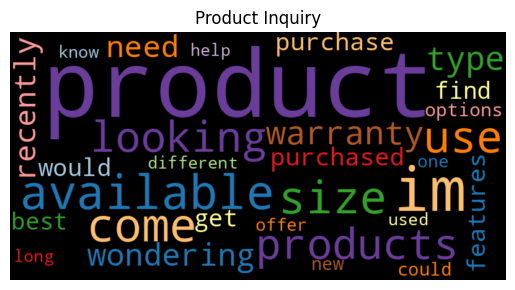

In [32]:
# Product Inquiry Class

wordcloud(product_query_count['freq'], title="Product Inquiry", max_words=30, stopwords=None)
# Generate a word cloud for the word frequencies of the "Product Inquiry" class

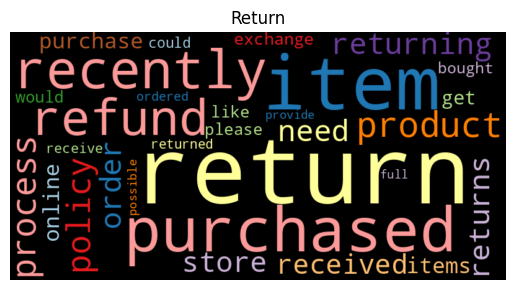

In [33]:
# Return Class
# Generate a word cloud for the word frequencies of the "Return" class
wordcloud(return_query_count['freq'], title="Return", max_words=30, stopwords=None)

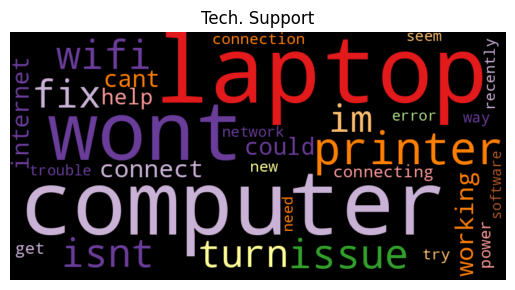

In [34]:
# Tech. Support Class
# Generate a word cloud for the word frequencies of the "Tech. Support" class
wordcloud(tech_query_count['freq'], title="Tech. Support", max_words=30, stopwords=None)